In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Transverse Ising Chain using VQE

The hamiltonian is given by $$ H = -\sum_
{\langle ij\rangle} J_{ij}Z_iZ_j - h\sum_{j} X_j,$$
the sum over $\langle ij\rangle$ denotes the interaction between all nearest neighbors. Periodic conditions will be assumed in this notebook.

In [2]:
num_spins = 5

J = np.array([1 for n in range(num_spins)])
h = 1 # External magnetic field

obs = [qml.PauliZ(i%num_spins) @ qml.PauliZ((i+1)%num_spins) for i in range(num_spins)]

H_int = qml.Hamiltonian(-1*J, obs) # Interaction hamiltonian
H_ext = qml.Hamiltonian([-h]*num_spins, [qml.PauliX(i) for i in range(num_spins)])# Transverse field
H = H_int + H_ext

print(H)

  (-1) [X0]
+ (-1) [X1]
+ (-1) [X2]
+ (-1) [X3]
+ (-1) [X4]
+ (-1) [Z0 Z1]
+ (-1) [Z1 Z2]
+ (-1) [Z2 Z3]
+ (-1) [Z3 Z4]
+ (-1) [Z4 Z0]


In [3]:
def get_hamiltonian(J, h, num_spins):
    
    # Asume periodic boundary conditions
    obs = [qml.PauliZ(i%num_spins) @ qml.PauliZ((i+1)%num_spins) for i in range(num_spins)]

    H_int = qml.Hamiltonian(-1*J, obs) # Interaction hamiltonian
    H_ext = qml.Hamiltonian([-h]*num_spins, [qml.PauliX(i) for i in range(num_spins)])# Transverse field
    H = H_int + H_ext

    return H

In [4]:
def circuit(params0, params1, wires):
    qml.StronglyEntanglingLayers(weights=params0, wires=wires)
    for i in range(len(wires)):
        qml.Rot(params1[i,0], params1[i,1], params1[i,2], wires=wires[i])

In [5]:
def VQE(H, num_spins, dev, opt, conv_tol, max_iterations):
    
    @qml.qnode(dev)
    def cost_fn(params0, params1):
        circuit(params0, params1, range(num_spins))
        return qml.expval(H)
    
    shape = qml.StronglyEntanglingLayers.shape(n_layers=3, n_wires=num_spins)
    params0 = 2*np.pi*np.random.random(shape)
    
    params1 = np.pi*np.random.random((num_spins, 3))
    
    energy_opt = [cost_fn(params0, params1)]
    params_opt = [[params0, params1]]
    
    for n in range(max_iterations):
        [params0, params1], prev_energy = opt.step_and_cost(cost_fn, params0, params1)

        energy_opt.append(cost_fn(params0, params1))
        params_opt.append([params0, params1])

        conv = np.abs(energy_opt[-1] - prev_energy)

        if conv <= conv_tol:
            break
            
    E0 = energy_opt[-1] / num_spins # Ground state energy per site
    
    # Calculate the transverse magnetization m_x = <sum_j X_j>
    @qml.qnode(dev)
    def magnetization(params):
        circuit(params[0], params[1], range(num_spins))
        return [qml.expval(qml.PauliX(i)) for i in range(num_spins)]

    M0 = np.sum(magnetization(params_opt[-1])) / num_spins
    
    return E0, M0

def exact(H):
    
    H_matrix = qml.matrix(H)
    
    w, v = np.linalg.eigh(H_matrix)
    E0 = w[0] / num_spins
    
    M_op = qml.PauliX(wires=0) # Magnetization in the x direction
    for i in range(1, num_spins):
        M_op += qml.PauliX(wires=i)
    M_op = qml.matrix(M_op)
    
    M0 = (v[:,0].conjugate().T @ M_op @ v[:,0]) / num_spins # Get the expectation value in the ground state
    
    return E0, np.real(M0)

In [6]:
np.random.seed(99)

num_spins = 5

dev = qml.device("default.qubit", wires=num_spins)

opt = qml.AdamOptimizer()

max_iterations = 1000
conv_tol = 1e-03

J = np.array([1 for n in range(num_spins)])
h = np.linspace(0, 4, 20) # Vary the external magnetic field

E0_VQE = np.zeros_like(h)
M0_VQE = np.zeros_like(h)

E0_exact = np.zeros_like(h)
M0_exact = np.zeros_like(h)

for i in tqdm(range(20)):
    H = get_hamiltonian(J, h[i], num_spins)
    E0_VQE[i], M0_VQE[i] = VQE(H, num_spins, dev, opt, conv_tol, max_iterations)
    E0_exact[i], M0_exact[i] = exact(H)

100%|██████████| 20/20 [04:53<00:00, 14.66s/it]


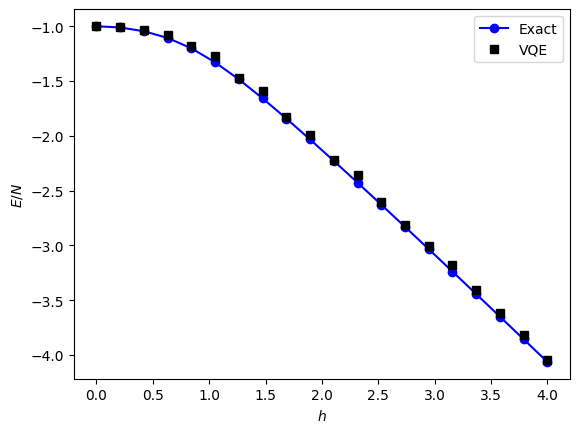

In [7]:
# Energy per site vs. h
plt.plot(h, E0_exact,'bo-', label='Exact')
plt.plot(h, E0_VQE,'ks',label='VQE')

plt.xlabel(r'$h$')
plt.ylabel(r'$E/N$')
plt.legend()

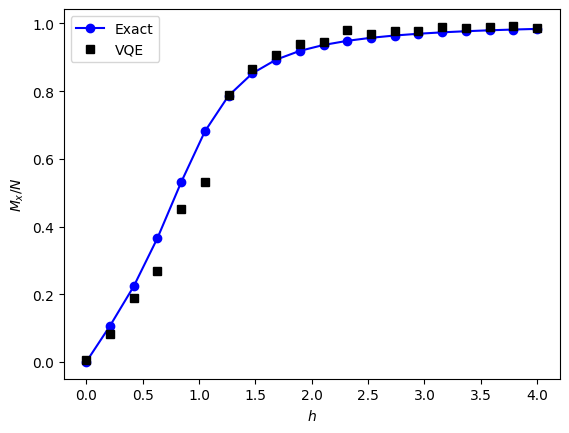

In [8]:
# Magnetization (in x) per site vs. h
plt.plot(h, M0_exact,'bo-', label='Exact')
plt.plot(h, M0_VQE,'ks',label='VQE')

plt.xlabel(r'$h$')
plt.ylabel(r'$M_x/N$')
plt.legend()